In [1]:
import os
import re
from pathlib import Path
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import random
random.seed()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
DATA_DIR = "20_newsgroups"

## Functions from lab

In [3]:
def clean_file_text(text):
    new_text = re.sub("Newsgroups:.*?\n", "", text)
    new_text = re.sub("Xref:.*?\n", "", new_text)
    new_text = re.sub("Path:.*?\n", "", new_text)
    new_text = re.sub("Date:.*?\n", "", new_text)
    new_text = re.sub("Followup-To:.*?\n", "", new_text)
    return new_text

In [4]:
def corpus_count_words(file_list):
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            word_counter.update(file_words)
    return word_counter

In [5]:
def corpus_count_words_new(file_list):
    
    import nltk
        ·
    from nltk.stem import LancasterStemmer, SnowballStemmer, PorterStemmer, WordNetLemmatizer
    nltk.download('stopwords')
    
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            
            # convert to lower case
            file_words = [word.lower() for word in file_words]
            
            # remove non-alphabetic
            file_words = [word for word in file_words if word.isalpha()]
            
            # remove stop words
            stop_words = stopwords.words('english')
            file_words = [word for word in file_words if not word in stop_words]
            
            # stemming of words
            lrStem = LancasterStemmer()
            sbStem = SnowballStemmer("english")
            wnLemm = WordNetLemmatizer()
            psStem = PorterStemmer()
            file_words = [lrStem.stem(word) for word in file_words]
            
            word_counter.update(file_words)
    return word_counter

In [6]:
def get_topic_name(file_path):
    return file_path.parent.name

def get_target(topic_name):
    topics = ['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 
     'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 
     'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics',
     'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']
    return topics.index(topic_name)

In [7]:
def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(10,10))
    plt.matshow(cm, fignum=1)
    
    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets+1)))
    plt.yticks(list(range(num_targets+1)))

## Q1

In [8]:
all_files = [pth for pth in Path(DATA_DIR).glob("**/*") if pth.is_file() and not pth.name.startswith(".")]

In [9]:
def binary_baseline_data(file_list, num_words = 1000):
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    return X, y

In [10]:
# get the baseline data
X, y = binary_baseline_data(all_files)

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
# set C=0.1 from 
clf = LogisticRegression(C=0.1).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.8563977995284704
Test accuracy: 0.7201666666666666


**Binary_baseline LogisticRegression with C=0.1**
<br>Train accuracy: 0.8563977995284704
<br>Test accuracy: 0.7201666666666666

### Q1 (a)

**feature set：** the features, encoded unigramly, are the top 1000 common wards selected by the code
<br>  *word_list = [word for (word, freq) in news_cnt.most_common(num_words)]*
<br><br>**the amount of data：** we split train and test data as 7:3 ratio, total number of documents are 19997.
<br>**hyper-parameters：** we set C=0.1 as hyperparameter (explained later - Inverse of regularization strength)

### Q1 (b)

Modify the following function:

In [11]:
def binary_improved_data(file_list, num_words = 1000):
    
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import LancasterStemmer, SnowballStemmer, PorterStemmer, WordNetLemmatizer
    nltk.download('stopwords')
    
    # Calculate word count in corpus
    news_cnt = corpus_count_words_new(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            
            # convert to lower case
            file_words = [word.lower() for word in file_words]
            
            # remove non-alphabetic
            file_words = [word for word in file_words if word.isalpha()]
            
            # remove stop words
            stop_words = stopwords.words('english')
            file_words = [word for word in file_words if not word in stop_words]
            
            # stemming of words
            # LancasterStemmer was choosen for best performance
            lrStem = LancasterStemmer()
            sbStem = SnowballStemmer("english")
            wnLemm = WordNetLemmatizer()
            psStem = PorterStemmer()
            file_words = [lrStem.stem(word) for word in file_words]
            
            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q1 (c)

Modify the following partial code to calculate the train and test accuracy and answer the question in the markdown cell below

In [12]:
# get the improved data
X, y = binary_improved_data(all_files)

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
# set c=0.1 from Q3
clf = LogisticRegression(C=0.1).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\austi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\austi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Train accuracy: 0.8864756733585768
Test accuracy: 0.7786666666666666


Model | Train Accuracy | Test Accuracy
--- | --- | ---
binary_baseline | 0.8563977995284704 | 0.7201666666666666
binary_improved | **0.8864756733585768** | **0.7786666666666666**

both train and test accuracy imporved

### Q1 (d)

Modify the partial code below

In [13]:
def random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here
    for i in range(1,num_tests+1):
        
        # split to train and test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

        # train a logistic regression classifier
        #set c=0.1 from Q3
        clf = LogisticRegression(C=0.1).fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)

        train_results.append(train_accuracy)
        test_results.append(test_accuracy)
        # report results
       # print("Train accuracy: {}".format(train_accuracy))
       # print("Test accuracy: {}".format(test_accuracy))

    
    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

### Q1 (e)

Use the following code to calculate the mean accuracy and 95% confidence interval over 10 random splits

In [14]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.8856397799528472
Train confidence interval over 10 random splits: [0.8848836251895075, 0.8863959347161868]
Test mean accuracy over 10 random splits: 0.7769833333333334
Test confidence interval over 10 random splits: [0.7749690346521263, 0.7789976320145404]


**A 95% confidence interval states a range of values $[\mu \pm h]$ that within 95% confidence(probability) that the value of a parameter (true mean of population) lies within it. They are more informative than singe trial since more trials will decrease overfitting and the interval of confidence interval, and CI uses T-distribution to predict the mean of entire population - statistical sampling.**


### Q1 (f)

Modify the partial code below

In [15]:
def random_cm(X, y, num_tests):
    # cm_list is a list of confusion matrices for the different random splits of the dataset
    cm_list = []
    
    # Write your code here
    for i in range(1,num_tests+1):
        # split to train and test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

        # train a logistic regression classifier
        #set c=0.1 from Q3
        clf = LogisticRegression(C=0.1).fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)
        
        cm = confusion_matrix(y_test, y_test_predict)
        cm_list.append(cm)
    # sum the confusion matrices and return the combined confusion matrix
    combined_cm = pd.Panel(cm_list).sum(axis=0)
    
    # validate return type
    assert isinstance(combined_cm, pd.DataFrame), "return type"
    
    return combined_cm

### Q1 (g)

Use the following code to produce a confusion matrix for 10 random splits

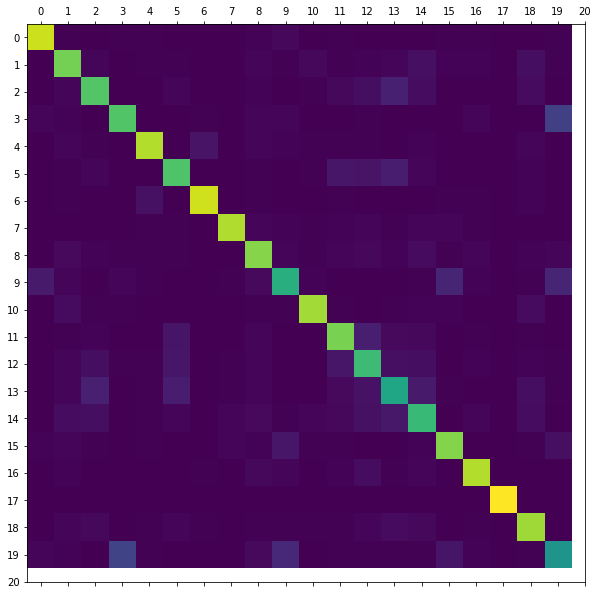

In [16]:
cm10 = random_cm(X, y, num_tests = 10)
plot_confusion_matrix(cm10)

In [17]:
pd.DataFrame(cm10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2735,14,5,15,23,2,6,0,34,65,5,17,10,10,11,21,15,0,2,23
1,7,2341,49,6,20,12,10,7,50,17,68,17,27,57,122,25,31,0,115,23
2,0,49,2171,7,7,53,8,3,25,6,14,58,107,255,100,5,9,0,88,2
3,40,32,2,2160,8,6,12,5,46,51,10,3,20,4,5,8,39,0,6,567
4,5,44,14,6,2625,6,153,1,37,29,13,18,13,10,34,1,6,0,41,6
5,0,22,52,2,5,2145,3,7,15,8,22,176,162,221,48,3,9,0,34,2
6,2,17,4,1,131,3,2751,1,15,6,9,21,3,8,10,14,15,0,25,4
7,1,6,6,4,17,23,4,2617,39,24,12,24,43,15,49,41,20,0,7,5
8,11,78,29,16,20,18,3,7,2430,44,22,36,67,24,85,14,41,0,33,54
9,213,35,7,39,17,11,9,14,72,1866,24,11,10,8,17,303,34,0,21,302


**Classes such as 'talk.politics.mideast' and 'talk.politics.misc' are easily confused with each other since they are all in politics topic, corresponding documents might contain many common important words.**

## Q2

### Q2 (a)

Modify the partial code below

In [18]:
def feature_num(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for p in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
        subset_size = int(p*X.shape[1])
        X_train_subset = X_train.iloc[:, 0:subset_size]
        X_test_subset = X_test.iloc[:, 0:subset_size]
        # Write your code here to calculate train_accuracy and test_accuracy for the current subset of features
       
        # train a logistic regression classifier
        #set c=0.1 from Q3
        clf = LogisticRegression(C=0.1).fit(X_train_subset, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train_subset)
        y_test_predict = clf.predict(X_test_subset)
        
        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        
        # add to result_list
        result_list.append((p, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["num_features", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q2 (b)

Use the following code to plot the train and test accuracy for the different feature sets sizes

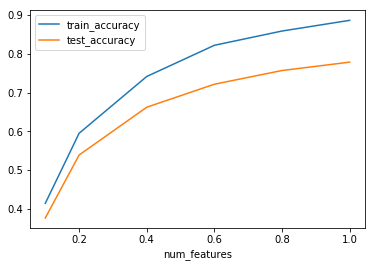

In [19]:
feature_num_df = feature_num(X, y)
feature_num_df.plot(x="num_features", y=["train_accuracy", "test_accuracy"])

**More features lead to higher accuracy, train accuracy increases faster than test accuracy, test accuracy's increase slow down after reaching 70%**

## Q3

### Q3 (a)

Modify the partial code below

In [20]:
def hyperparameter(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for param in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        # Write your code here to calculate train_accuracy and test_accuracy for the current parameter value
        
        # train a logistic regression classifier
        clf = LogisticRegression(C=param).fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)
        
        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        
        # add to result_list
        result_list.append((param, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["param", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q3 (b)

Use the following code to plot the train and test accuracy for the different the parameters

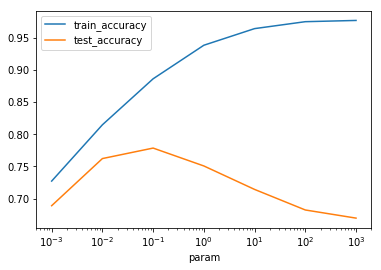

In [45]:
param_df = hyperparameter(X, y)
param_df.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True)

**train accracy increases as C increase, while test accuracy increases initially, reaching the peak with C=0.1, following with decrease as C continues increasing. Due to large C -> less regulation, easily overfitting.**

## Q4

### Q4 (a)

Modify the partial code below

In [21]:
def tf_improved_data(file_list, num_words = 1000):
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import LancasterStemmer, SnowballStemmer, PorterStemmer, WordNetLemmatizer
    nltk.download('stopwords')
    
    # Calculate word count in corpus
    news_cnt = corpus_count_words_new(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    df = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            
            # convert to lower case
            file_words = [word.lower() for word in file_words]
            
            # remove non-alphabetic
            file_words = [word for word in file_words if word.isalpha()]
            
            # remove stop words
            stop_words = stopwords.words('english')
            file_words = [word for word in file_words if not word in stop_words]
            
            # stemming of words
            # LancasterStemmer was choosen for best performance
            lrStem = LancasterStemmer()
            sbStem = SnowballStemmer("english")
            wnLemm = WordNetLemmatizer()
            psStem = PorterStemmer()
            file_words = [lrStem.stem(word) for word in file_words]
            
            #change binary into TF
            for word in word_list:
                df.append(file_words.count(word))
            df_rows.append(df)
            df = []   
            
    X = pd.DataFrame(df_rows, columns = word_list)   
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q4 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [22]:
X_tf, y_tf = tf_improved_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X_tf, y_tf, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\austi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\austi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Train mean accuracy over 10 random splits: 0.8977495177538044
Train confidence interval over 10 random splits: [0.8955181584262712, 0.8999808770813376]
Test mean accuracy over 10 random splits: 0.7652500000000001
Test confidence interval over 10 random splits: [0.7625509032105722, 0.767949096789428]


Model | Train Accuracy | Test Accuracy
--- | --- | ---
binary_baseline | 0.8563977995284704 | 0.7201666666666666
binary_improved | 0.8864756733585768 | 0.7786666666666666
tf_improved | **0.8977495177538044** | **0.7652500000000001**

**binary encoding still performs better in this dataset, since term-frequency may ingore those important but rare term, while binary encoding only considers if ther term appeared or not, dramatically more TF may also overfit the model**

## Q5

### Q5 (a)

Modify the partial code below

In [55]:
def nb_random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here
    
    for i in range(1,num_tests+1):
        
        # split to train and test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

        # train a Naive Bayes classifier
        clf_gNB = GaussianNB()
        clf_bNB = BernoulliNB()
        clf_mNB = MultinomialNB()
        
        clf = clf_mNB
        
        clf.fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)

        train_results.append(train_accuracy)
        test_results.append(test_accuracy)
    
    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

In [ ]:
# get the improved data
X, y = binary_improved_data(all_files)

### Q5 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [56]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = nb_random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.788397513752947
Train confidence interval over 10 random splits: [0.78688854711509, 0.7899064803908039]
Test mean accuracy over 10 random splits: 0.7364833333333333
Test confidence interval over 10 random splits: [0.7323587862470411, 0.7406078804196254]


Model | Train Accuracy | Test Accuracy
--- | --- | ---
binary_baseline | 0.8563977995284704 | 0.7201666666666666
binary_improved | 0.8864756733585768 | 0.7786666666666666
tf_improved | 0.8977495177538044 | 0.7652500000000001
GaussianNB | 0.6079802814888906 | 0.5338666666666667
BernoulliNB | 0.6897620918768308 | 0.64605
MultinomialNB | **0.788397513752947** | **0.7364833333333333**

**binary boolean encoded logistic regression performs better. Naïve Bayes assumption base is that all the features are conditionally independent(for a known class, the value of each feature in the class is independent) - the words in this case are seemingly dependent in the document.**

p.s. in our case, among 3 NB methods, multinomialNB > BernoulliNB > GaussianNB
<br>https://www.quora.com/What-is-the-difference-between-the-the-Gaussian-Bernoulli-Multinomial-and-the-regular-Naive-Bayes-algorithms
<br>https://datascience.stackexchange.com/questions/27624/difference-between-bernoulli-and-multinomial-naive-bayes

## Q6

In [23]:
def is_graduate_student():
    # ** Graduate students: change the return value to True **
    return True

### Q6 (a)

Modify the partial code below

In [24]:
def binary_med_data(file_list, num_words = 1000):

    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import LancasterStemmer, SnowballStemmer, PorterStemmer, WordNetLemmatizer
    nltk.download('stopwords')
    
    # Calculate word count in corpus
    news_cnt = corpus_count_words_new(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    y= []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            
            # convert to lower case
            file_words = [word.lower() for word in file_words]
            
            # remove non-alphabetic
            file_words = [word for word in file_words if word.isalpha()]
            
            # remove stop words
            stop_words = stopwords.words('english')
            file_words = [word for word in file_words if not word in stop_words]
            
            # stemming of words
            # LancasterStemmer was choosen for best performance
            lrStem = LancasterStemmer()
            sbStem = SnowballStemmer("english")
            wnLemm = WordNetLemmatizer()
            psStem = PorterStemmer()
            file_words = [lrStem.stem(word) for word in file_words]
            
            df_rows.append([1 if word in file_words else 0 for word in word_list]) 
            
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    for file_path in file_list:
        if get_topic_name(file_path) == "sci.med":
            y.append(1)
        else:
            y.append(0)
   # y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q6 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [25]:
X, y = binary_med_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\austi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\austi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Train mean accuracy over 10 random splits: 0.9820032864185183
Train confidence interval over 10 random splits: [0.9816189754477747, 0.982387597389262]
Test mean accuracy over 10 random splits: 0.9745666666666667
Test confidence interval over 10 random splits: [0.9731160001701474, 0.976017333163186]


Model | Train Accuracy | Test Accuracy
--- | --- | ---
binary_baseline | 0.8563977995284704 | 0.7201666666666666
binary_improved | 0.8864756733585768 | 0.7786666666666666
tf_improved | 0.8977495177538044 | 0.7652500000000001
GaussianNB | 0.6079802814888906 | 0.5338666666666667
BernoulliNB | 0.6897620918768308 | 0.64605
MultinomialNB | 0.788397513752947 | 0.7364833333333333
Binary_Logistic | **0.9820032864185183** | **0.9745666666666667**

**A 95% confidence interval states a range of values $[\mu \pm h]$ that within 95% confidence(probability) that the value of a parameter (true mean of population) lies within it. Binary logistic regression outperformed multiclass logistic regression since in binary we only care if classifed as sci.med or not.**